<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2024-10-29 14:07:20--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2024-10-29 14:07:20--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2024-10-29 14:07:21 (33.1 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
%run 'utils.py'

In [ ]:
import argparse
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


def get_dataset(dataset_name=datasets.CIFAR10, batch_size=128, train_dataset_transforms=transforms.Compose([transforms.ToTensor()]), test_dataset_transforms=transforms.Compose([transforms.ToTensor()]), cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = dataset_name(PATH, train=True, download=True,
        transform=train_dataset_transforms)

    val_dataset = dataset_name(PATH, train=False, download=True,
        transform=test_dataset_transforms)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    #objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()


    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        #update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)


    return avg_top1_acc, avg_top5_acc, avg_loss


def main(model, dataset, batch_size=128, lr=0.1, epochs=15, cuda=False, data_augmentation=False, normalization=False,
         data_transformation=transforms.Compose([transforms.ToTensor()]), sched=False, affichages_intermediaires=False):
    """
    Main function to train and evaluate a model on a specified dataset.

    Parameters:
    model: The instantiated model to train and evaluate.
    dataset: The name or path of the dataset to use.
    batch_size: Batch size for training and testing (default is 128).
    lr: Learning rate for the optimizer (default is 0.1).
    epochs: Number of training epochs (default is 5).
    cuda: If True, use GPU for training; otherwise, use CPU (default is False).
    data_augmentation: If True, apply data augmentation to the training data, re-transforming at each epoch (default is False).
    normalization: If True, apply normalization transformation (default is False).
    data_transformation: Transformation to apply to the dataset.
    sched: If True, use an exponential learning rate scheduler (default is False).
    affichages_intermediaires: If True, display intermediate plots of loss and accuracy during training (default is False).

    Returns:
    Dictionary containing:
        - "loss_train": List of average training loss per epoch.
        - "loss_test": List of average testing loss per epoch.
        - "acc_train": List of top-1 accuracy for the training set per epoch.
        - "acc_test": List of top-1 accuracy for the test set per epoch.
    """

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    # Define learning rate scheduler if activated
    if sched:
        lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # If using GPU, move model and criterion to GPU
    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Load the data
    if not data_augmentation:
        # Load the dataset once if no data augmentation is used. Apply normalization or no transformation as specified.
        train, test = get_dataset(dataset, batch_size, train_dataset_transforms=data_transformation,
                                  test_dataset_transforms=data_transformation, cuda=cuda)

    # Initialize plots if intermediate displays are enabled
    if affichages_intermediaires:
        plot = AccLossPlot()
        global loss_plot
        loss_plot = TrainLossPlot()

    # Initialize lists to store averages for each epoch
    list_acc_test = []
    list_acc_train = []
    list_loss_test = []
    list_loss_train = []

    # Loop over each epoch
    for i in tqdm(range(epochs)):
        # If data augmentation is enabled, re-transform the training dataset each epoch
        if data_augmentation:
            train, test = get_dataset(dataset, batch_size, train_dataset_transforms=data_transformation, cuda=cuda)

        # Training phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)

        # Testing phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        # Update learning rate scheduler if activated
        if sched:
            lr_sched.step()

        # Update plots if intermediate displays are enabled
        if affichages_intermediaires:
            plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        # Append results to lists
        list_acc_train.append(top1_acc.avg)
        list_loss_train.append(loss.avg)
        list_acc_test.append(top1_acc_test.avg)
        list_loss_test.append(loss_test.avg)

    return {"loss_train": list_loss_train, "loss_test": list_loss_test, "acc_train": list_acc_train, "acc_test": list_acc_test}



In [ ]:
def afficher_plots(result, title, nb_epochs):

    x_values = np.arange(len(result["acc_train"]))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy for train and test
    axs[0].plot(x_values, result["acc_train"], label="acc. train")
    axs[0].plot(x_values, result["acc_test"], label="acc. test")
    axs[0].set_title("Train/ test accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot loss for train and test
    axs[1].plot(x_values, result["loss_train"], label="loss train")
    axs[1].plot(x_values, result["loss_test"], label="loss test")
    axs[1].set_title("Train/ test Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    fig.suptitle(title)

    plt.show()



In [ ]:
result = main(ConvNet(), datasets.MNIST, 128, 0.1, epochs=30, cuda=True)

100%|██████████| 30/30 [04:31<00:00,  9.05s/it]


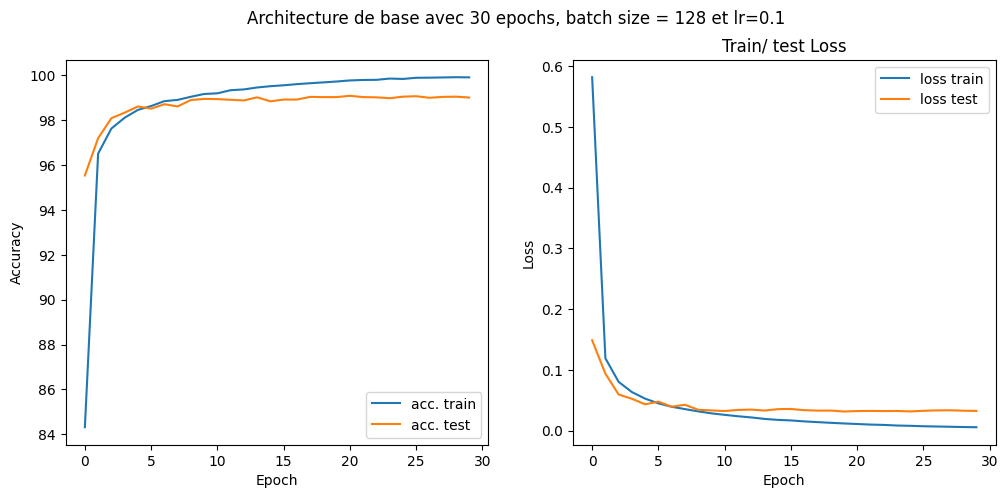

In [ ]:
nb_epochs=30
batch_size = 128
lr = 0.1
afficher_plots(result, f"Architecture de base avec {nb_epochs} epochs, batch size = {batch_size} et lr={lr}", nb_epochs)

# Reproduction de l'architecture

 - conv1 : 32 convolutions 5 5, followed by ReLU
 - pool1 : max-pooling 2 2
 - conv2 : 64 convolutions 5 5, followed by ReLU
 - pool2 : max-pooling 2 2
 - conv3 : 64 convolutions 5 5, followed by ReLU
 - pool3 : max-pooling 2 2
 - fc4 : fully-connected, 1000 output neurons, followed by ReLU
 - fc5 : fully-connected, 10 neurons output, followed by softmax

In [ ]:
class ConvNet2(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, dropout = None, batch_norm = False):
        super(ConvNet2, self).__init__()

        self.dropout = dropout
        self.batch_norm = batch_norm

        # We first define the convolution and pooling layers as a features extractor
        conv_layers = [nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        ]



        if self.batch_norm:           # add batch normalization
          conv_layers.insert(1, nn.BatchNorm2d(32))
          conv_layers.insert(5, nn.BatchNorm2d(64))
          conv_layers.insert(9, nn.BatchNorm2d(64))

        self.features = nn.Sequential(*conv_layers)


        sequential_layers = [nn.Linear(1024, 1000),  # fc4
            nn.ReLU(),
            nn.Linear(1000, 10)]      # fc5

        if self.dropout:
            sequential_layers.insert(2, nn.Dropout(p = self.dropout))   # add Dropout between fc4 and fc5


        # Fully connected layers as a classifier
        self.classifier = nn.Sequential(*sequential_layers) # Reminder: The softmax is included in the loss


    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


In [ ]:
nb_epochs = 30
result = main(ConvNet2(), datasets.CIFAR10, 128, 0.1, epochs=nb_epochs, cuda=True)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:18<00:00, 10.63s/it]


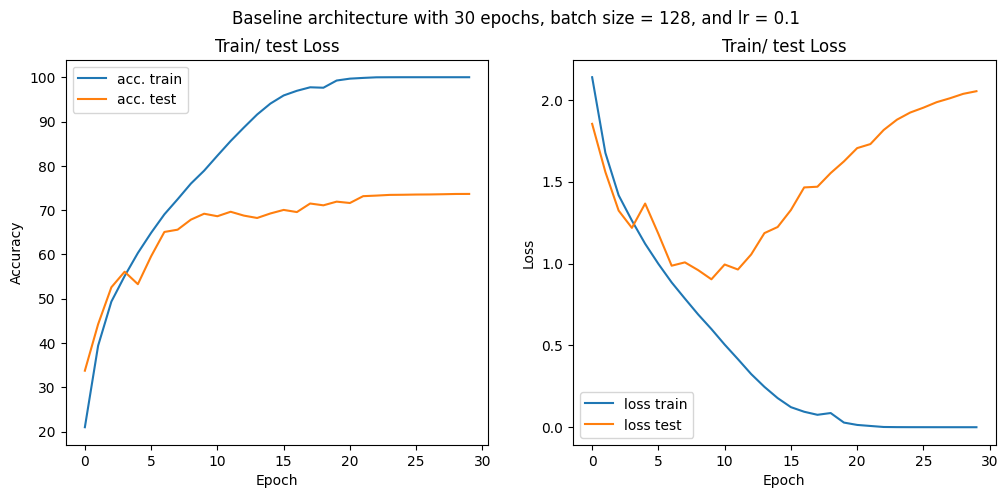

In [ ]:
nb_epochs = 30
batch_size = 128
lr = 0.1
afficher_plots(result, f"Baseline architecture with {nb_epochs} epochs, batch size = {batch_size}, and lr = {lr}", nb_epochs)

# Experiments on the learning rate and batch size



**Experiments on the learning rate**

In [ ]:
dic_lr = {}
for lr in [1e-4, 0.001, 0.01, 0.1, 0.5]:
   dic_lr[lr]= main(ConvNet2(), datasets.CIFAR10, 128, lr, epochs = 30, cuda=True)

for lr, result in dic_lr.items():
  print(result["loss_test"])

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:29<00:00, 10.98s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:25<00:00, 10.86s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:10<00:00, 10.36s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:10<00:00, 10.35s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [05:22<00:00, 10.74s/it]

[2.302487433711185, 2.302428173113473, 2.3023691509343402, 2.3023103732097, 2.302252141735222, 2.3021944716006897, 2.3021373356444927, 2.302080456214615, 2.3020238393469703, 2.301967783819271, 2.301912138733683, 2.3018570459341703, 2.3018022519123704, 2.301747684237323, 2.3016936024533043, 2.301639765123778, 2.3015862929670114, 2.3015331075161316, 2.3014802449866187, 2.301427605785901, 2.3013751959498925, 2.3013229007962384, 2.30127082897138, 2.301218711877171, 2.301166649106183, 2.3011144444912293, 2.301062324379064, 2.301009980938103, 2.30095750168909, 2.300904729698278]
[2.301699233960502, 2.3009682335431063, 2.3002234169199496, 2.299429899529566, 2.2985494016092036, 2.2975316258925425, 2.296317713170112, 2.294859735271599, 2.2930821949922584, 2.290881881230994, 2.2881380063069017, 2.284678676460363, 2.280205648156661, 2.2742910807645775, 2.2661861256708073, 2.254517280602757, 2.236962430084808, 2.2099017342434655, 2.1705682760552514, 2.1221337680575214, 2.069866367533237, 2.0278724

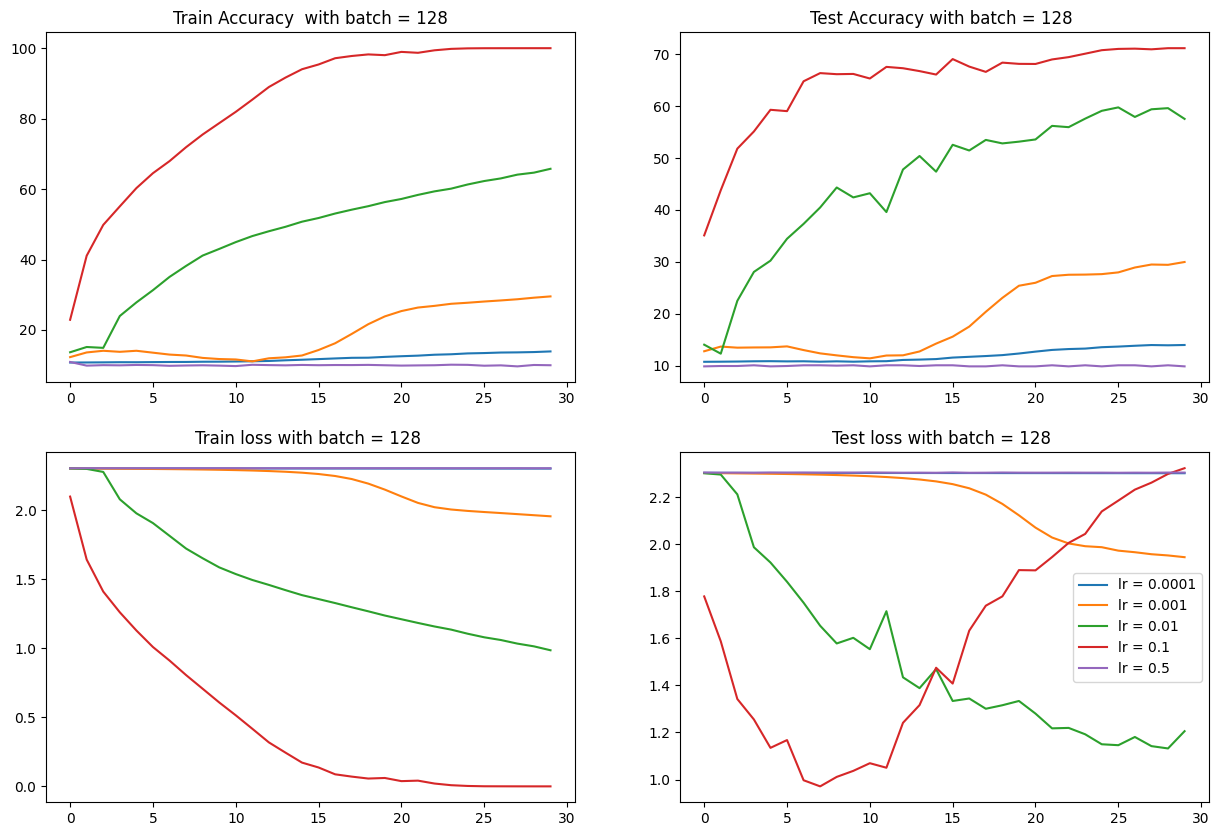

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(len(result["acc_train"]))
for lr, result in dic_lr.items():
  axs[0,0].plot(x_values, result["acc_train"], label=f"lr = {lr}")
  axs[0,1].plot(x_values, result["acc_test"], label=f"lr = {lr}")
  axs[1,0].plot(x_values, result["loss_train"], label=f"lr = {lr}")
  axs[1,1].plot(x_values, result["loss_test"], label=f"lr = {lr}")

axs[0,0].set_title("Train Accuracy  with batch = 128")
axs[0,1].set_title("Test Accuracy with batch = 128 ")
axs[1,0].set_title("Train loss with batch = 128 ")
axs[1,1].set_title("Test loss with batch = 128 ")

plt.legend()
plt.show()

**Experiments on batch size**

In [ ]:
nb_epochs = 20
lr = 0.01
dic_batch_size = {}

for batch_size in [32, 64, 128]:
   dic_batch_size[batch_size]= main(ConvNet2(), datasets.CIFAR10, batch_size, lr, epochs = nb_epochs, cuda=True)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 20/20 [05:30<00:00, 16.51s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 20/20 [04:03<00:00, 12.16s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 20/20 [03:30<00:00, 10.55s/it]


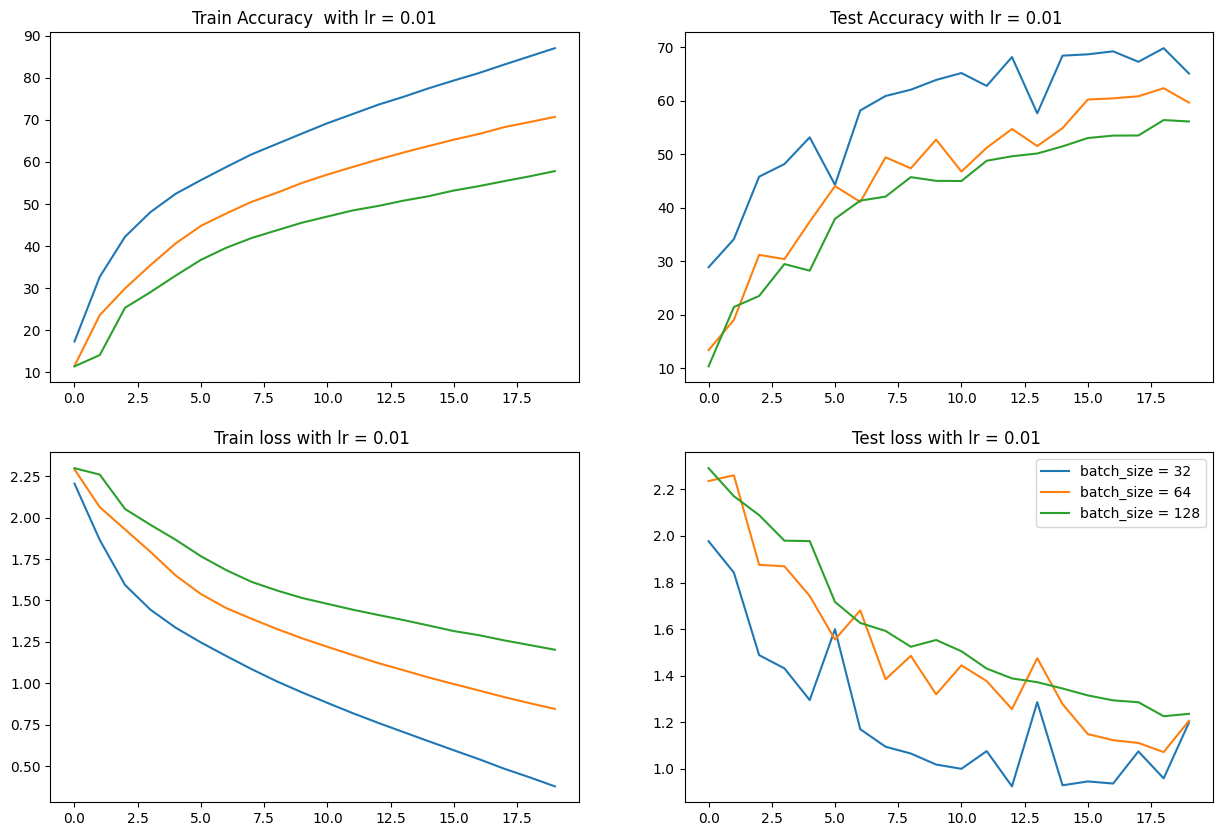

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

for batch_size, result in dic_batch_size.items():
  axs[0,0].plot(x_values, result["acc_train"], label=f"batch_size = {batch_size}")
  axs[0,1].plot(x_values, result["acc_test"], label=f"batch_size = {batch_size}")
  axs[1,0].plot(x_values, result["loss_train"], label=f"batch_size = {batch_size}")
  axs[1,1].plot(x_values, result["loss_test"], label=f"batch_size = {batch_size}")

axs[0,0].set_title(f"Train Accuracy  with lr = {lr}")
axs[0,1].set_title(f"Test Accuracy with lr = {lr} ")
axs[1,0].set_title(f"Train loss with lr = {lr} ")
axs[1,1].set_title(f"Test loss with lr = {lr} ")

plt.legend()
plt.show()

# Part 3: Results improvements

## 3.1 Standardization of examples

In [ ]:
normalization_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.491, 0.482, 0.447] , # Nomalization of the train dataset
                         std = [0.202, 0.199, 0.201])
        ])

In [ ]:
nb_epochs = 15
result_norm = main(ConvNet2(), datasets.CIFAR10, 32, 0.01, cuda=True, epochs=nb_epochs, data_transformation=normalization_transform, affichages_intermediaires=False)
result = main(ConvNet2(), datasets.CIFAR10, 32, 0.01, epochs=nb_epochs, cuda=True)


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [06:11<00:00, 24.76s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [04:21<00:00, 17.43s/it]


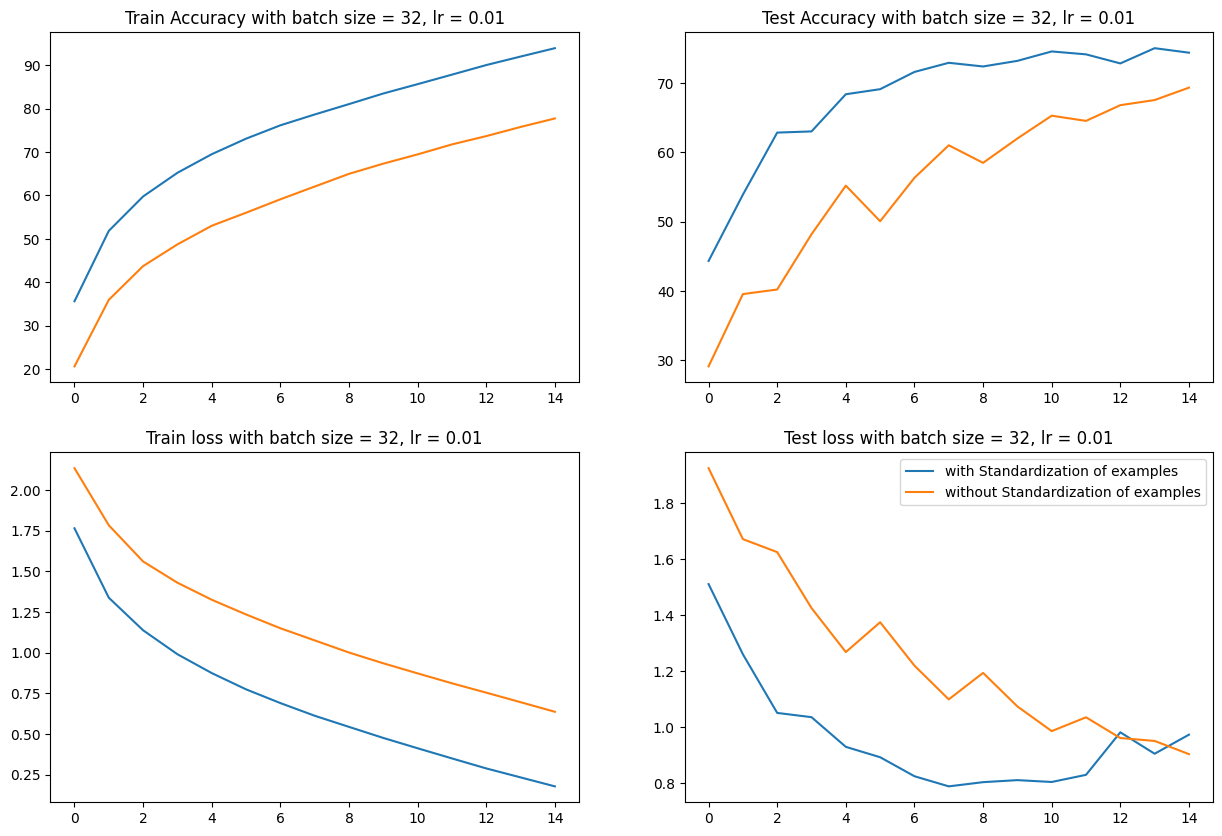

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

# plots with Standardization of examples
axs[0,0].plot(x_values, result_norm["acc_train"], label=f"with Standardization of examples")
axs[0,1].plot(x_values, result_norm["acc_test"], label=f"with Standardization of examples")
axs[1,0].plot(x_values, result_norm["loss_train"], label=f"with Standardization of examples")
axs[1,1].plot(x_values, result_norm["loss_test"], label=f"with Standardization of examples")

# plots without Standardization of examples
axs[0,0].plot(x_values, result["acc_train"], label=f"without Standardization of examples")
axs[0,1].plot(x_values, result["acc_test"], label=f"without Standardization of examples")
axs[1,0].plot(x_values, result["loss_train"], label=f"without Standardization of examples")
axs[1,1].plot(x_values, result["loss_test"], label=f"without Standardization of examples")

axs[0,0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0,1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1,0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1,1].set_title("Test loss with batch size = 32, lr = 0.01")

plt.legend()
plt.show()

**Other types of normalization**

In [ ]:
# Define functions for L1 and L2 normalizations
def l1_normalize(tensor):
    # Divide each example by its L1 norm
    return tensor / (torch.sum(torch.abs(tensor), dim=1, keepdim=True) + 1e-10)

def l2_normalize(tensor):
    # Divide each example by its L2 norm
    return tensor / (torch.norm(tensor, p=2, dim=1, keepdim=True) + 1e-10)

# Define normalization transformations
l1_norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: l1_normalize(x))  # L1 normalization
])

l2_norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: l2_normalize(x))  # L2 normalization
])

In [ ]:
nb_epochs = 15
batch_size = 32
learning_rate = 0.01

# Results with different normalization methods
result_standard = main(ConvNet2(), datasets.CIFAR10, batch_size, learning_rate, cuda=True, epochs=nb_epochs, data_transformation=normalization_transform, affichages_intermediaires=False)
result_l1 = main(ConvNet2(), datasets.CIFAR10, batch_size, learning_rate, cuda=True, epochs=nb_epochs, data_transformation=l1_norm_transform, affichages_intermediaires=False)
result_l2 = main(ConvNet2(), datasets.CIFAR10, batch_size, learning_rate, cuda=True, epochs=nb_epochs, data_transformation=l2_norm_transform, affichages_intermediaires=False)
result_no_norm = main(ConvNet2(), datasets.CIFAR10, batch_size, learning_rate, cuda=True, epochs=nb_epochs)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [05:06<00:00, 20.44s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [04:32<00:00, 18.19s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [04:54<00:00, 19.65s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [04:07<00:00, 16.51s/it]


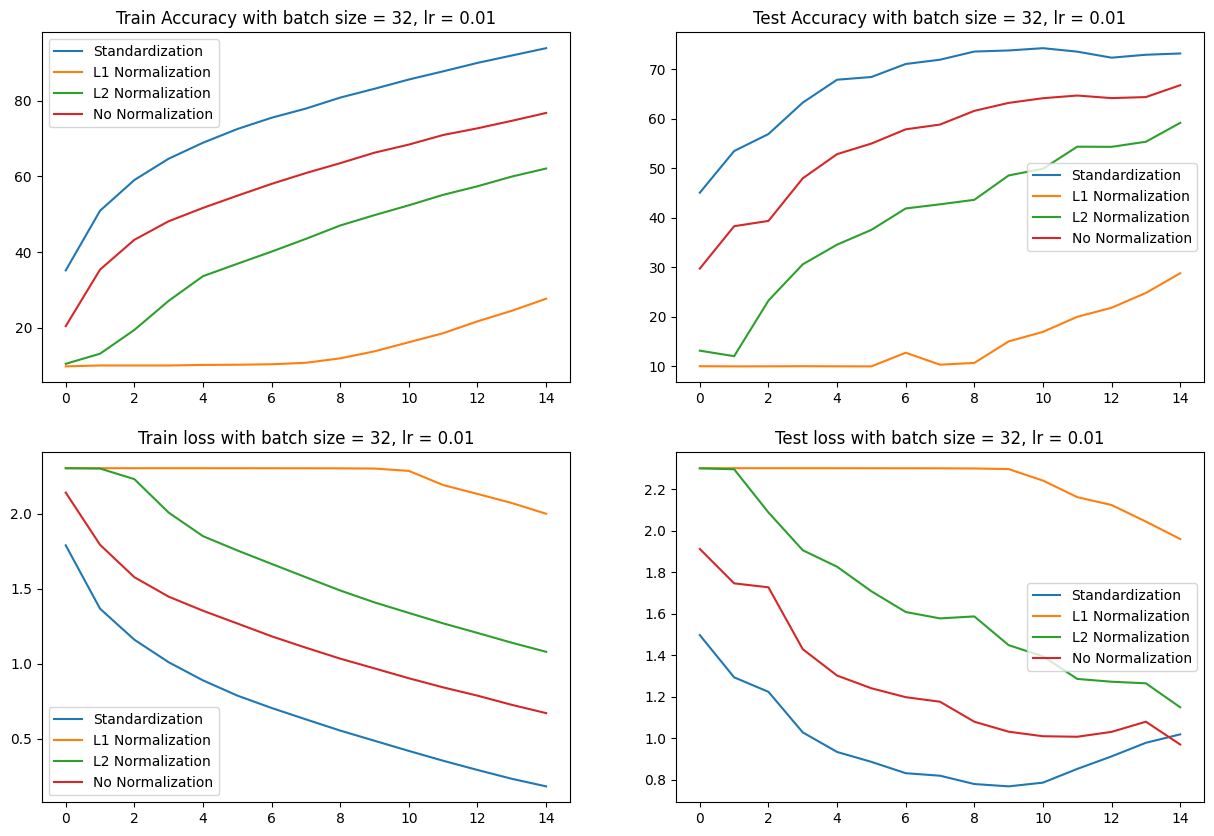

In [ ]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
x_values = np.arange(nb_epochs)

# Plot with standard normalization
axs[0, 0].plot(x_values, result_standard["acc_train"], label="Standardization")
axs[0, 1].plot(x_values, result_standard["acc_test"], label="Standardization")
axs[1, 0].plot(x_values, result_standard["loss_train"], label="Standardization")
axs[1, 1].plot(x_values, result_standard["loss_test"], label="Standardization")

# Plot with L1 normalization
axs[0, 0].plot(x_values, result_l1["acc_train"], label="L1 Normalization")
axs[0, 1].plot(x_values, result_l1["acc_test"], label="L1 Normalization")
axs[1, 0].plot(x_values, result_l1["loss_train"], label="L1 Normalization")
axs[1, 1].plot(x_values, result_l1["loss_test"], label="L1 Normalization")

# Plot with L2 normalization
axs[0, 0].plot(x_values, result_l2["acc_train"], label="L2 Normalization")
axs[0, 1].plot(x_values, result_l2["acc_test"], label="L2 Normalization")
axs[1, 0].plot(x_values, result_l2["loss_train"], label="L2 Normalization")
axs[1, 1].plot(x_values, result_l2["loss_test"], label="L2 Normalization")

# Plot without normalization
axs[0, 0].plot(x_values, result_no_norm["acc_train"], label="No Normalization")
axs[0, 1].plot(x_values, result_no_norm["acc_test"], label="No Normalization")
axs[1, 0].plot(x_values, result_no_norm["loss_train"], label="No Normalization")
axs[1, 1].plot(x_values, result_no_norm["loss_test"], label="No Normalization")

# Titles and legends
axs[0, 0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0, 1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1, 0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1, 1].set_title("Test loss with batch size = 32, lr = 0.01")

for ax in axs.flat:
    ax.legend()

plt.show()

# 3.2 Data Augmentation

In [ ]:
# Training set transformation with data augmentation
train_dataset_augmentation = transforms.Compose([
        transforms.RandomCrop(28),            # Random crop of 28x28
        transforms.Resize(32),                # Resize images to 32x32 without changing the architecture
        transforms.RandomHorizontalFlip(0.5), # Random horizontal flip with a probability of 0.5
        transforms.ToTensor()                 # Converts images to tensors
    ])

In [ ]:
nb_epochs = 15
result_aug = main(ConvNet2(), datasets.CIFAR10, batch_size=32, lr = 0.01, epochs=nb_epochs, cuda=True, data_augmentation=True, data_transformation=train_dataset_augmentation)
result = main(ConvNet2(), datasets.CIFAR10, 32, lr = 0.01, epochs=nb_epochs, cuda=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


  7%|▋         | 1/15 [00:30<07:08, 30.63s/it]

Files already downloaded and verified
Files already downloaded and verified


 13%|█▎        | 2/15 [00:54<05:44, 26.46s/it]

Files already downloaded and verified
Files already downloaded and verified


 20%|██        | 3/15 [01:18<05:05, 25.42s/it]

Files already downloaded and verified
Files already downloaded and verified


 27%|██▋       | 4/15 [01:42<04:32, 24.82s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 5/15 [02:06<04:05, 24.55s/it]

Files already downloaded and verified
Files already downloaded and verified


 40%|████      | 6/15 [02:30<03:39, 24.44s/it]

Files already downloaded and verified
Files already downloaded and verified


 47%|████▋     | 7/15 [02:54<03:12, 24.12s/it]

Files already downloaded and verified
Files already downloaded and verified


 53%|█████▎    | 8/15 [03:16<02:45, 23.63s/it]

Files already downloaded and verified
Files already downloaded and verified


 60%|██████    | 9/15 [03:39<02:21, 23.56s/it]

Files already downloaded and verified
Files already downloaded and verified


 67%|██████▋   | 10/15 [04:03<01:58, 23.70s/it]

Files already downloaded and verified
Files already downloaded and verified


 73%|███████▎  | 11/15 [04:27<01:35, 23.77s/it]

Files already downloaded and verified
Files already downloaded and verified


 80%|████████  | 12/15 [04:51<01:11, 23.71s/it]

Files already downloaded and verified
Files already downloaded and verified


 87%|████████▋ | 13/15 [05:15<00:47, 23.70s/it]

Files already downloaded and verified
Files already downloaded and verified


 93%|█████████▎| 14/15 [05:37<00:23, 23.38s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [06:01<00:00, 24.09s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [03:52<00:00, 15.52s/it]


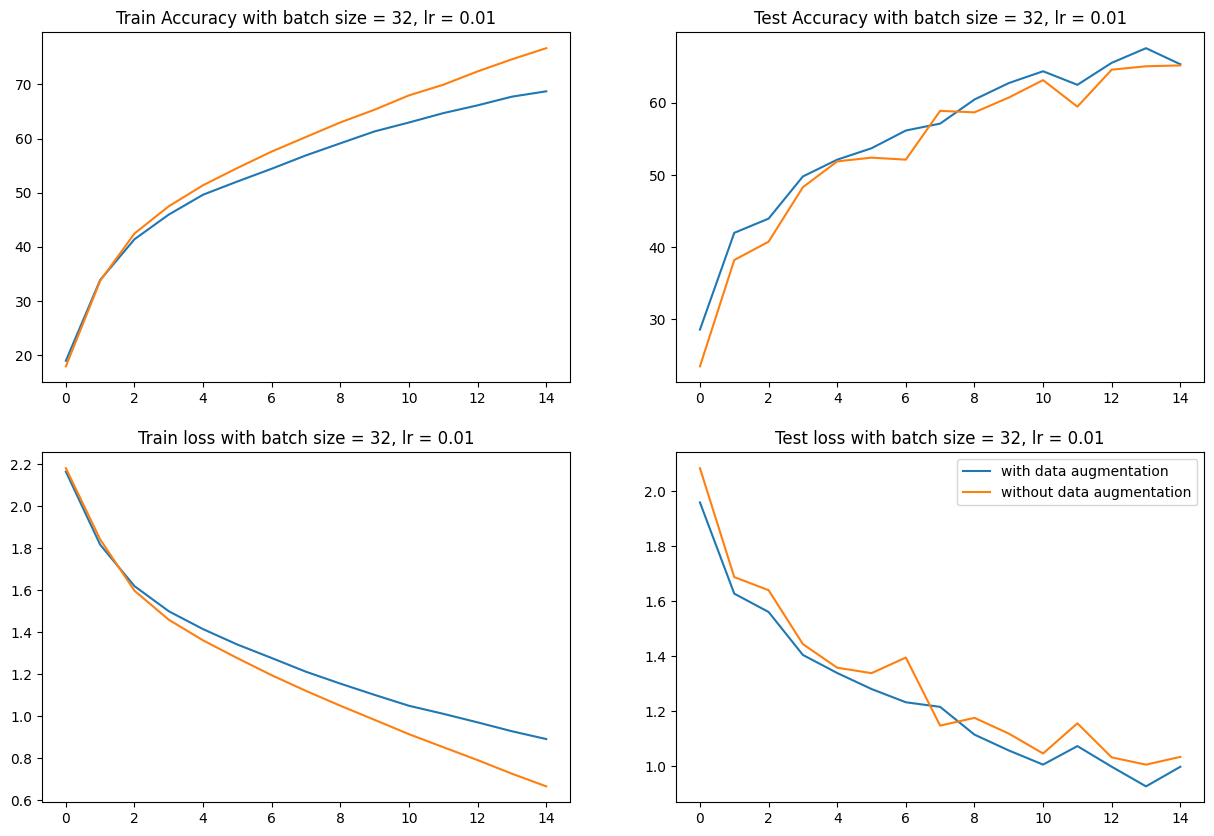

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

# plots with data augmentation
axs[0,0].plot(x_values, result_aug["acc_train"], label=f"with data augmentation")
axs[0,1].plot(x_values, result_aug["acc_test"], label=f"with data augmentation")
axs[1,0].plot(x_values, result_aug["loss_train"], label=f"with data augmentation")
axs[1,1].plot(x_values, result_aug["loss_test"], label=f"with data augmentation")

# plots without data augmentation
axs[0,0].plot(x_values, result["acc_train"], label=f"without data augmentation")
axs[0,1].plot(x_values, result["acc_test"], label=f"without data augmentation")
axs[1,0].plot(x_values, result["loss_train"], label=f"without data augmentation")
axs[1,1].plot(x_values, result["loss_test"], label=f"without data augmentation")

axs[0,0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0,1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1,0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1,1].set_title("Test loss with batch size = 32, lr = 0.01")

plt.legend()
plt.show()

**Other types of data augmentation**

In [ ]:
# Transformation with Random Rotation
train_rotation_augmentation = transforms.Compose([
    transforms.RandomRotation(10),         # Random rotation within 10 degrees
    transforms.ToTensor()
])

# Transformation with Gaussian Blur
train_blur_augmentation = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Gaussian blur
    transforms.ToTensor()
])

In [ ]:
nb_epochs = 15
batch_size = 32
learning_rate = 0.01

result_rotation = main(ConvNet2(), datasets.CIFAR10, batch_size=batch_size, lr=learning_rate, epochs=nb_epochs, cuda=True, data_augmentation=True, data_transformation=train_rotation_augmentation)
result_blur = main(ConvNet2(), datasets.CIFAR10, batch_size=batch_size, lr=learning_rate, epochs=nb_epochs, cuda=True, data_augmentation=True, data_transformation=train_blur_augmentation)
result_no_aug = main(ConvNet2(), datasets.CIFAR10, batch_size=batch_size, lr=learning_rate, epochs=nb_epochs, cuda=True)


  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 32.8k/170M [00:00<16:48, 169kB/s]
  0%|          | 65.5k/170M [00:00<17:35, 161kB/s]
  0%|          | 98.3k/170M [00:00<17:47, 160kB/s]
  0%|          | 229k/170M [00:00<08:12, 346kB/s] 
  0%|          | 459k/170M [00:01<04:36, 614kB/s]
  1%|          | 918k/170M [00:01<02:27, 1.15MB/s]
  1%|          | 1.70M/170M [00:01<01:10, 2.41MB/s]
  1%|          | 2.06M/170M [00:01<01:07, 2.50MB/s]
  2%|▏         | 3.44M/170M [00:01<00:33, 4.99MB/s]
  2%|▏         | 4.10M/170M [00:01<00:31, 5.25MB/s]
  3%|▎         | 5.51M/170M [00:01<00:22, 7.47MB/s]
  4%|▎         | 6.39M/170M [00:01<00:22, 7.26MB/s]
  5%|▍         | 7.83M/170M [00:02<00:21, 7.74MB/s]
  5%|▌         | 9.24M/170M [00:02<00:17, 9.19MB/s]
  6%|▌         | 10.3M/170M [00:02<00:18, 8.80MB/s]
  7%|▋         | 11.6M/170M [00:02<00:15, 10.0MB/s]
  7%|▋         | 12.7M/170M [00:02<00:17, 9.15MB/s]
  8%|▊         | 14.1M/170M [00:02<00:17, 9.04MB/s]
  9%|▉         | 15.4M/170M

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


  7%|▋         | 1/15 [00:44<10:21, 44.39s/it]

Files already downloaded and verified
Files already downloaded and verified


 13%|█▎        | 2/15 [01:03<06:24, 29.57s/it]

Files already downloaded and verified
Files already downloaded and verified


 20%|██        | 3/15 [01:24<05:08, 25.68s/it]

Files already downloaded and verified
Files already downloaded and verified


 27%|██▋       | 4/15 [01:43<04:14, 23.17s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 5/15 [02:04<03:41, 22.16s/it]

Files already downloaded and verified
Files already downloaded and verified


 40%|████      | 6/15 [02:23<03:11, 21.27s/it]

Files already downloaded and verified
Files already downloaded and verified


 47%|████▋     | 7/15 [02:43<02:46, 20.79s/it]

Files already downloaded and verified
Files already downloaded and verified


 53%|█████▎    | 8/15 [03:03<02:24, 20.60s/it]

Files already downloaded and verified
Files already downloaded and verified


 60%|██████    | 9/15 [03:23<02:01, 20.24s/it]

Files already downloaded and verified
Files already downloaded and verified


 67%|██████▋   | 10/15 [03:43<01:41, 20.28s/it]

Files already downloaded and verified
Files already downloaded and verified


 73%|███████▎  | 11/15 [04:03<01:19, 19.99s/it]

Files already downloaded and verified
Files already downloaded and verified


 80%|████████  | 12/15 [04:23<01:00, 20.16s/it]

Files already downloaded and verified
Files already downloaded and verified


 87%|████████▋ | 13/15 [04:43<00:40, 20.00s/it]

Files already downloaded and verified
Files already downloaded and verified


 93%|█████████▎| 14/15 [05:03<00:20, 20.00s/it]

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


  7%|▋         | 1/15 [00:41<09:46, 41.92s/it]

Files already downloaded and verified
Files already downloaded and verified


 13%|█▎        | 2/15 [01:23<09:05, 41.94s/it]

Files already downloaded and verified
Files already downloaded and verified


 20%|██        | 3/15 [02:06<08:24, 42.03s/it]

Files already downloaded and verified
Files already downloaded and verified


 27%|██▋       | 4/15 [02:47<07:41, 41.99s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 5/15 [03:29<06:58, 41.80s/it]

Files already downloaded and verified
Files already downloaded and verified


 40%|████      | 6/15 [04:10<06:15, 41.73s/it]

Files already downloaded and verified
Files already downloaded and verified


 47%|████▋     | 7/15 [04:52<05:34, 41.80s/it]

Files already downloaded and verified
Files already downloaded and verified


 53%|█████▎    | 8/15 [05:36<04:55, 42.27s/it]

Files already downloaded and verified
Files already downloaded and verified


 60%|██████    | 9/15 [06:17<04:12, 42.10s/it]

Files already downloaded and verified
Files already downloaded and verified


 67%|██████▋   | 10/15 [06:59<03:29, 41.96s/it]

Files already downloaded and verified
Files already downloaded and verified


 73%|███████▎  | 11/15 [07:41<02:47, 42.00s/it]

Files already downloaded and verified
Files already downloaded and verified


 80%|████████  | 12/15 [08:23<02:05, 41.85s/it]

Files already downloaded and verified
Files already downloaded and verified


 87%|████████▋ | 13/15 [09:04<01:23, 41.75s/it]

Files already downloaded and verified
Files already downloaded and verified


 93%|█████████▎| 14/15 [09:45<00:41, 41.49s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [10:26<00:00, 41.78s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [03:46<00:00, 15.10s/it]


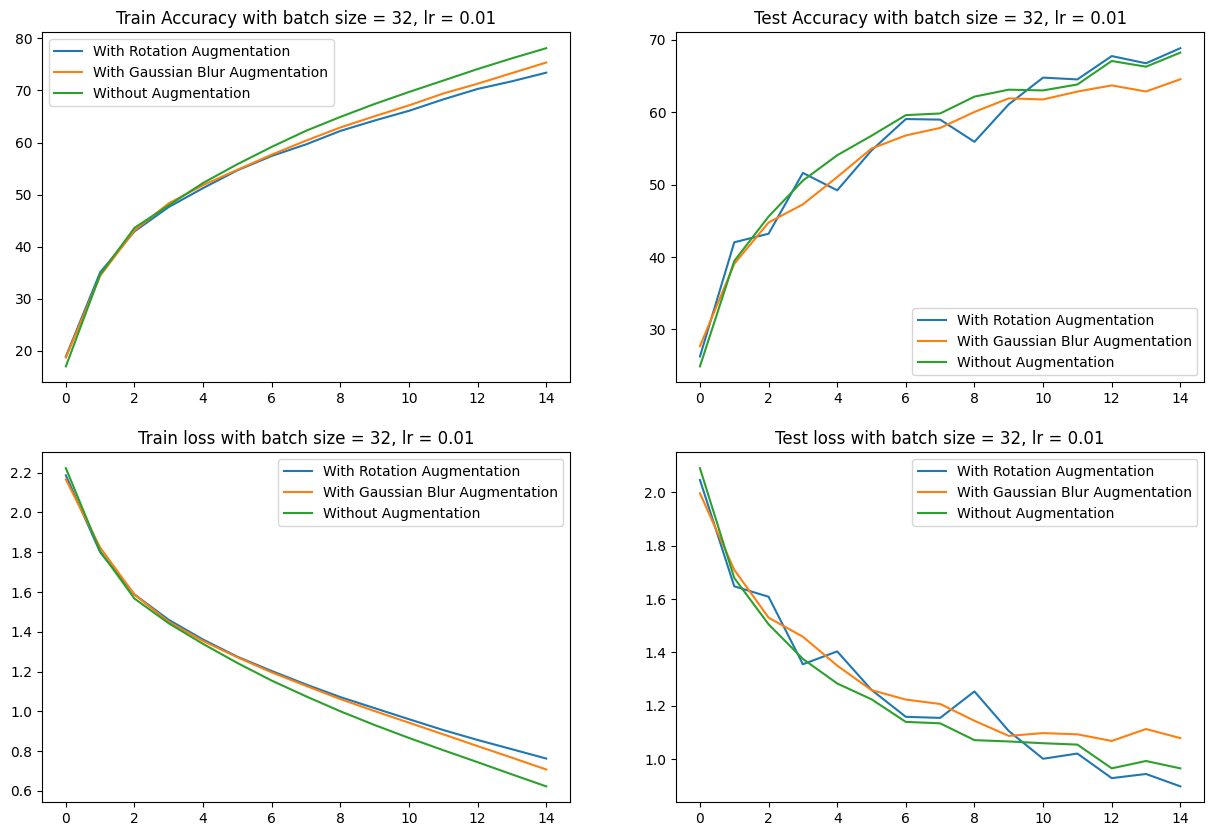

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
x_values = np.arange(nb_epochs)

# Plots with rotation augmentation
axs[0, 0].plot(x_values, result_rotation["acc_train"], label="With Rotation Augmentation")
axs[0, 1].plot(x_values, result_rotation["acc_test"], label="With Rotation Augmentation")
axs[1, 0].plot(x_values, result_rotation["loss_train"], label="With Rotation Augmentation")
axs[1, 1].plot(x_values, result_rotation["loss_test"], label="With Rotation Augmentation")

# Plots with Gaussian blur augmentation
axs[0, 0].plot(x_values, result_blur["acc_train"], label="With Gaussian Blur Augmentation")
axs[0, 1].plot(x_values, result_blur["acc_test"], label="With Gaussian Blur Augmentation")
axs[1, 0].plot(x_values, result_blur["loss_train"], label="With Gaussian Blur Augmentation")
axs[1, 1].plot(x_values, result_blur["loss_test"], label="With Gaussian Blur Augmentation")

# Plots without augmentation
axs[0, 0].plot(x_values, result_no_aug["acc_train"], label="Without Augmentation")
axs[0, 1].plot(x_values, result_no_aug["acc_test"], label="Without Augmentation")
axs[1, 0].plot(x_values, result_no_aug["loss_train"], label="Without Augmentation")
axs[1, 1].plot(x_values, result_no_aug["loss_test"], label="Without Augmentation")

# Titles and legends
axs[0, 0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0, 1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1, 0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1, 1].set_title("Test loss with batch size = 32, lr = 0.01")

for ax in axs.flat:
    ax.legend()

plt.show()

## 3.3 Variants of the optimisation algorithm

In [ ]:
# Import the package
import torch.optim.lr_scheduler

In [ ]:
result_optim = main(ConvNet2(), datasets.CIFAR10, 32, 0.01, cuda=True, sched=True, affichages_intermediaires=False)
result = main(ConvNet2(), datasets.CIFAR10, 32, lr = 0.01, epochs=nb_epochs, cuda=True)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [04:00<00:00, 16.03s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [03:49<00:00, 15.27s/it]


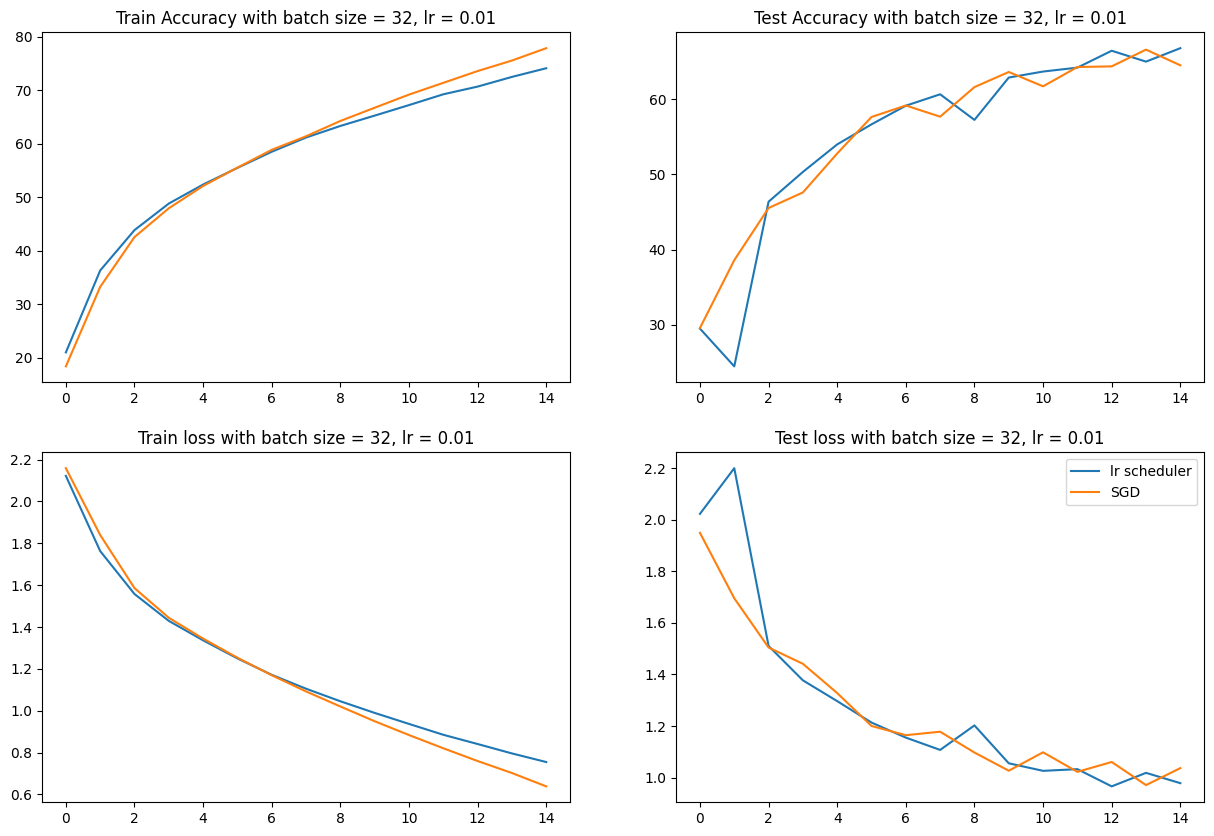

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

# plots with lr schedule
axs[0,0].plot(x_values, result_optim["acc_train"], label=f"lr scheduler")
axs[0,1].plot(x_values, result_optim["acc_test"], label=f"lr scheduler")
axs[1,0].plot(x_values, result_optim["loss_train"], label=f"lr scheduler")
axs[1,1].plot(x_values, result_optim["loss_test"], label=f"lr scheduler")

# plots with SGD
axs[0,0].plot(x_values, result["acc_train"], label=f"SGD")
axs[0,1].plot(x_values, result["acc_test"], label=f"SGD")
axs[1,0].plot(x_values, result["loss_train"], label=f"SGD")
axs[1,1].plot(x_values, result["loss_test"], label=f"SGD")

axs[0,0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0,1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1,0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1,1].set_title("Test loss with batch size = 32, lr = 0.01")

plt.legend()
plt.show()

## Dropout

In [ ]:
dic_p = {}
for p in [0, 0.3, 0.5, 0.9]:
   dic_p[p]= main(ConvNet2(dropout=p), datasets.CIFAR10, 32, 0.01, epochs=30, cuda=True)
for p, result in dic_p.items():
  print(result["loss_test"])

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:30<00:00, 17.01s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:28<00:00, 16.96s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:30<00:00, 17.03s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:28<00:00, 16.95s/it]

[2.099682672716939, 1.682313627709215, 1.6296557469870716, 1.4077976391719171, 1.433120451796169, 1.2165553811640024, 1.1843571150645662, 1.1524426919964557, 1.0867741307892358, 1.0580989882207146, 0.9993030128006737, 1.0694307431626244, 0.9611767428561141, 0.9472359140840964, 0.9222302408264087, 1.0075905934309426, 0.9492379456472854, 1.0651059821010016, 0.989407042344919, 1.0683746458813785, 1.0820525641829823, 1.1319923139989567, 1.516170376215499, 1.3480391649011605, 1.509858309270475, 1.5634764936594918, 1.5483998066891496, 1.8190040406518089, 1.838109871830803, 1.6806770285097554]
[1.93658847702197, 1.6978799260843296, 1.5049827175018506, 1.4652950287626956, 1.3340032700532543, 1.2060931644881496, 1.2760091985757358, 1.1038613776429393, 1.3070378221642858, 1.0655172703365168, 0.9590547267621318, 0.9314742646278283, 0.8955691255890904, 1.0164341903723086, 0.8523926966296979, 0.8880734970203985, 0.8758390241156752, 0.8745093555115282, 0.9569852494012815, 0.8455219644898424, 0.86346

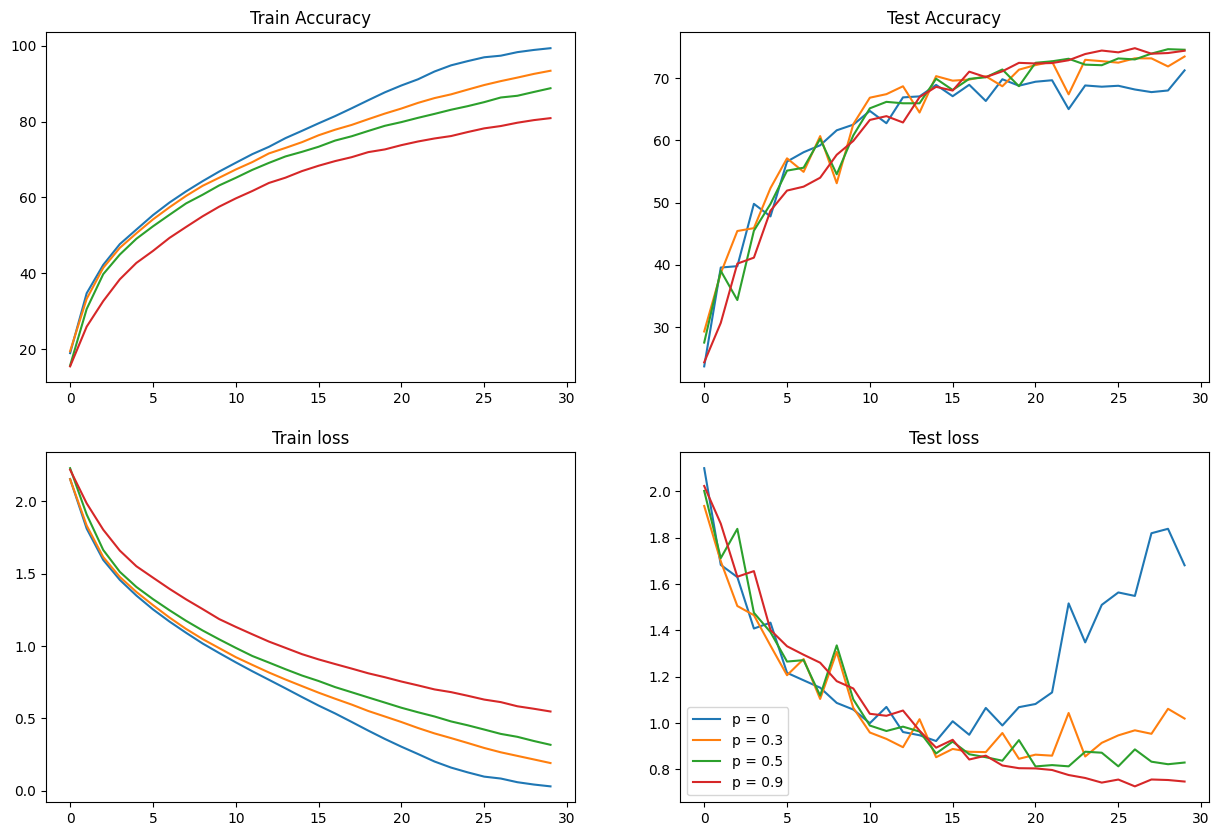

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(len(result["acc_train"]))
for p, result in dic_p.items():
  axs[0,0].plot(x_values, result["acc_train"], label=f"p= {p}")
  axs[0,1].plot(x_values, result["acc_test"], label=f"p = {p}")
  axs[1,0].plot(x_values, result["loss_train"], label=f"p = {p}")
  axs[1,1].plot(x_values, result["loss_test"], label=f"p = {p}")

axs[0,0].set_title("Train Accuracy")
axs[0,1].set_title("Test Accuracy")
axs[1,0].set_title("Train loss")
axs[1,1].set_title("Test loss")

plt.legend()
plt.show()

# Use of batch normalization

In [ ]:
nb_epochs = 30
result_bn = main(ConvNet2(batch_norm = True), datasets.CIFAR10, 32, 0.01, epochs=nb_epochs, cuda=True)
result = main(ConvNet2(batch_norm = False), datasets.CIFAR10, 32, 0.01, epochs=nb_epochs, cuda=True)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:02<00:00, 16.07s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [07:23<00:00, 14.79s/it]


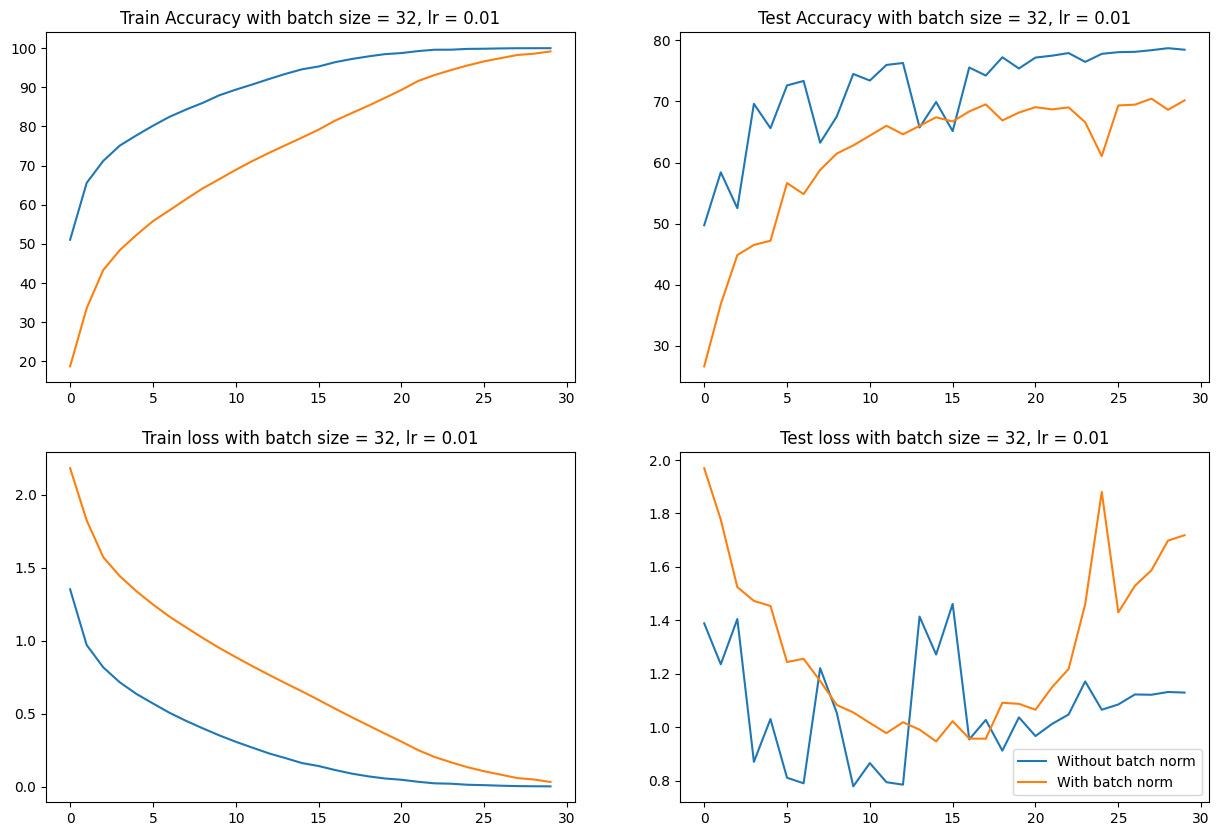

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

# Without batch norm
axs[0,0].plot(x_values, result_bn["acc_train"], label=f"Without batch norm")
axs[0,1].plot(x_values, result_bn["acc_test"], label=f"Without batch norm")
axs[1,0].plot(x_values, result_bn["loss_train"], label=f"Without batch norm")
axs[1,1].plot(x_values, result_bn["loss_test"], label=f"Without batch norm")

# With batch norm
axs[0,0].plot(x_values, result["acc_train"], label=f"With batch norm")
axs[0,1].plot(x_values, result["acc_test"], label=f"With batch norm")
axs[1,0].plot(x_values, result["loss_train"], label=f"With batch norm")
axs[1,1].plot(x_values, result["loss_test"], label=f"With batch norm")

axs[0,0].set_title("Train Accuracy with bastch size = 32, lr = 0.01")
axs[0,1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1,0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1,1].set_title("Test loss with batch size = 32, lr = 0.01")

plt.legend()
plt.show()

# Combination of techniques

In [ ]:
result_standard = main(ConvNet2(dropout = 0.5), datasets.CIFAR10, batch_size=32, lr=0.01, cuda=True, epochs=30, data_transformation=normalization_transform, affichages_intermediaires=False)
result = main(ConvNet2(), datasets.CIFAR10, batch_size=32, lr=0.01, epochs=30, cuda=True)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [12:29<00:00, 24.97s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [08:28<00:00, 16.96s/it]


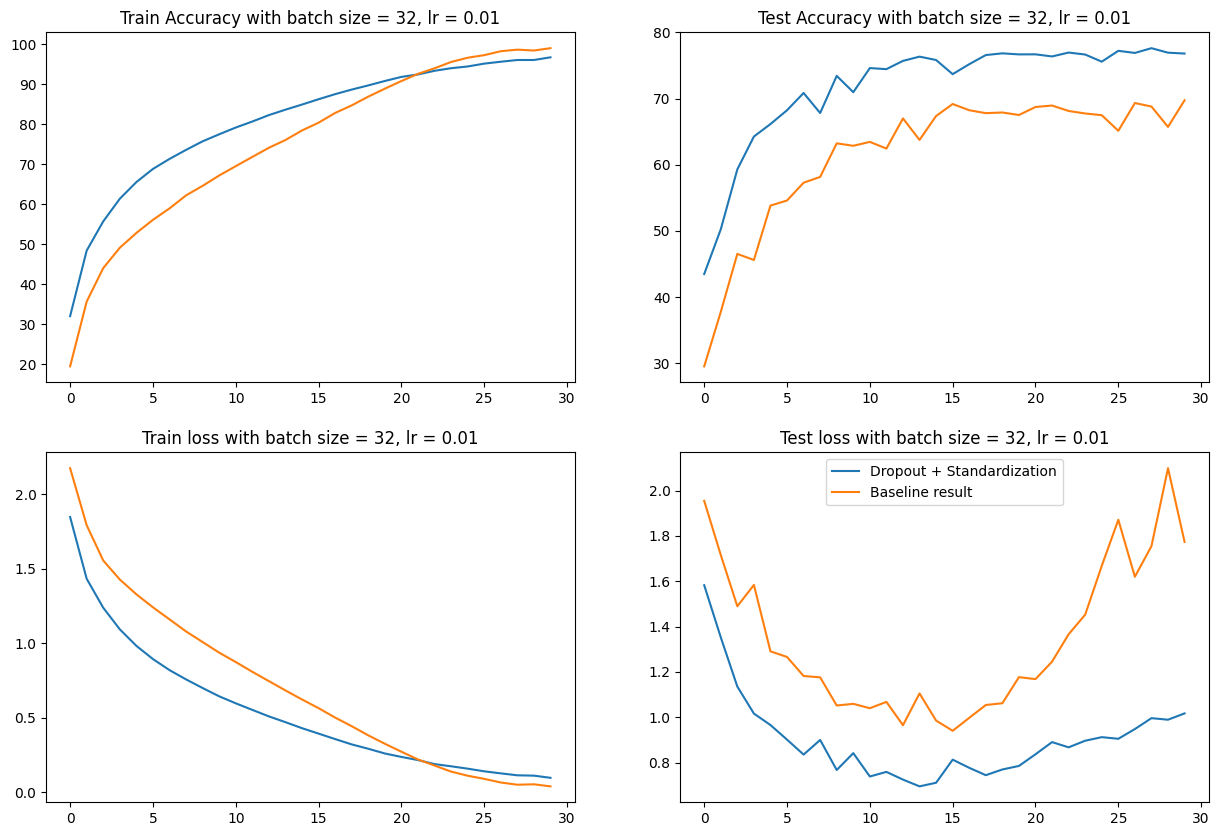

In [ ]:
nb_epochs = 30

fig, axs = plt.subplots(2,2, figsize = (15,10))
x_values = np.arange(nb_epochs)

# plots with improvements
axs[0,0].plot(x_values, result_standard["acc_train"], label=f"Dropout + Standardization")
axs[0,1].plot(x_values, result_standard["acc_test"], label=f"Dropout + Standardization")
axs[1,0].plot(x_values, result_standard["loss_train"], label=f"Dropout + Standardization")
axs[1,1].plot(x_values, result_standard["loss_test"], label=f"Dropout + Standardization")

# plots without improvements
axs[0,0].plot(x_values, result["acc_train"], label=f"Baseline result")
axs[0,1].plot(x_values, result["acc_test"], label=f"Baseline result")
axs[1,0].plot(x_values, result["loss_train"], label=f"Baseline result")
axs[1,1].plot(x_values, result["loss_test"], label=f"Baseline result")

axs[0,0].set_title("Train Accuracy with batch size = 32, lr = 0.01")
axs[0,1].set_title("Test Accuracy with batch size = 32, lr = 0.01")
axs[1,0].set_title("Train loss with batch size = 32, lr = 0.01")
axs[1,1].set_title("Test loss with batch size = 32, lr = 0.01")

plt.legend()
plt.show()